# Local adaptive time-stepping for a locally compressed monolayer due to a single proliferation event

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 7.5 # final time
rA = 1.5   # maximum interaction distance
separation = 0.15 # initial separation between daughter cells

dim = 2

seed=67
npr.seed(seed)

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim, separation), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim, separation),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim, separation)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], 0.0, proliferating=False) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, move cell there and add second daughter cells
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    
    # get division direction
    random_angle = 2.0 * np.pi * npr.rand()
    division_direction = np.array([np.cos(random_angle), np.sin(random_angle)])
    
    # update positions
    updated_position_parent = coords - 0.5 * separation * division_direction
    sheet[m].position = updated_position_parent   

    position_daughter = coords + 0.5 * separation * division_direction    
    
    # add daughter cell
    next_cell_index = len(sheet)
    daughter_cell = cl.Cell(next_cell_index, position_daughter, birthtime=0.0, proliferating=False)
    sheet.append(daughter_cell)
        
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [7]:
# plot function
# eigenvector must contain eigenvector corresponding to a single eigenvalue
def plot_eigenvector_on_population(cell_list, eigenvector, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    eigenvector = eigenvector.reshape((n_cells, -1))
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
        plt.plot([cell_list[i].position[0], cell_list[i].position[0] + eigenvector[i, 0]], [cell_list[i].position[1],cell_list[i].position[1]+eigenvector[i,1]])
    plt.show()

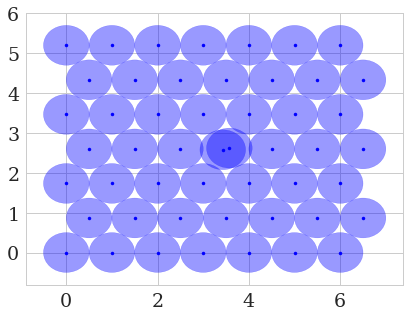

In [8]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

In [9]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


Initial step cubic 0.022304376240639606
Stability bound estimate cubic 0.05972564946540285
Initial step cubic 0.013831483646606588
Stability bound estimate cubic 0.08766735087508169
Initial step cubic 0.006185627532697802
Stability bound estimate cubic 0.0967257871448317


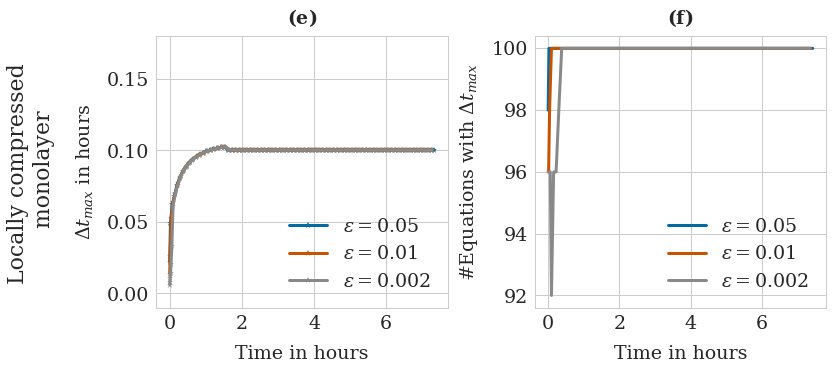

In [10]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace':0.2, 'wspace': 0.3})
#fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})


force = 'cubic'
epsilons = [0.05, 0.01, 0.002]

for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')

    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True,'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True}, seed=seed)
    #ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'local_adaptivity': True}, seed=seed)

    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax1.plot(ts[:-2], dts[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i])
    
    n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
    ax2.plot(ts[:-1], n_eq_per_level[2,:], label='$\epsilon=$'+str(eps), color=colors[i])

ax1.set_title(r'$\bf{(e)}$')
ax1.legend(loc='lower right')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t_{max}$ in hours')
ax1.text(-4.5, 0.01, 'Locally compressed\n        monolayer', fontsize=22, rotation='vertical')
ax1.set(ylim=[-0.01, 0.18])


#ax2.set(ylim=[-0.1, 1.2])
#ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

ax2.legend()
ax2.set(xlabel='Time in hours')
ax2.set(ylabel='#Equations with $\Delta t_{max}$')
ax2.set_title(r'$\bf{(f)}$')




plt.savefig('local_adap_local_mono.pdf', bbox_inches='tight')

In [11]:
# do preliminary measuring of the execution times
eps = 0.01
sheet = make_hexagonal_mesh(20)
len(sheet)

1522

In [12]:
#plot_population(sheet)

In [13]:
%%time
ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': False,'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True}, seed=seed)


CPU times: user 5.63 s, sys: 1.92 s, total: 7.55 s
Wall time: 9.2 s


In [14]:
%%time
ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': False,'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)


CPU times: user 5.73 s, sys: 3.42 s, total: 9.15 s
Wall time: 11.9 s


In [15]:
import cProfile

In [16]:
cProfile.run('models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], "write_to_file": False, "jacobian": models_ef[force].jacobian, "force_args": params[force], "local_adaptivity": True}, seed=seed)', sort=1)

         82799 function calls (82657 primitive calls) in 9.502 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       14    4.504    0.322    6.266    0.448 __init__.py:349(jacobian)
      134    1.825    0.014    1.825    0.014 {method 'reduce' of 'numpy.ufunc' objects}
       14    1.343    0.096    2.578    0.184 __init__.py:326(f)
      236    0.618    0.003    0.618    0.003 {method 'reshape' of 'numpy.ndarray' objects}
       14    0.403    0.029    6.765    0.483 euler_forward.py:424(_choose_dts)
       42    0.367    0.009    0.434    0.010 force_functions.py:157(__call__)
       14    0.106    0.008    0.134    0.010 force_functions.py:177(fp)
       84    0.098    0.001    0.098    0.001 {built-in method numpy.zeros}
    24352    0.066    0.000    0.076    0.000 cell.py:46(__init__)
       28    0.058    0.002    0.061    0.002 twodim_base.py:214(diag)
        1    0.023    0.023    9.375    9.375 euler_forward.py

In [17]:
cProfile.run('models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], "write_to_file": False, "jacobian": models_ef[force].jacobian, "force_args": params[force]}, seed=seed)', sort=1)

         85232 function calls (85210 primitive calls) in 14.687 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       16    6.549    0.409    9.394    0.587 __init__.py:349(jacobian)
      124    2.931    0.024    2.931    0.024 {method 'reduce' of 'numpy.ufunc' objects}
       16    2.254    0.141    4.172    0.261 __init__.py:326(f)
      195    1.016    0.005    1.016    0.005 {method 'reshape' of 'numpy.ndarray' objects}
        1    0.691    0.691   14.438   14.438 euler_forward.py:164(_do_global_adaptive_timestepping_with_stability)
       48    0.560    0.012    0.670    0.014 force_functions.py:157(__call__)
       16    0.188    0.012    0.233    0.015 force_functions.py:177(fp)
       96    0.161    0.002    0.161    0.002 {built-in method numpy.zeros}
    29205    0.082    0.000    0.082    0.000 {built-in method numpy.array}
       16    0.066    0.004    0.141    0.009 __init__.py:228(<listcomp>)
       32    

Initial step cubic 0.030948752289243944
Stability bound estimate cubic 0.07381457849427374
Initial step cubic 0.01384070278751034
Stability bound estimate cubic 0.10338777986641061
Initial step cubic 0.0043768145225974164
Stability bound estimate cubic 0.1906067442394846
Initial step cubic 0.022304376240639866
Stability bound estimate cubic 0.31071989343024464
Initial step cubic 0.013831483646606593
Stability bound estimate cubic 0.23233295705291157
Initial step cubic 0.00437389917426483
Stability bound estimate cubic 0.10186778481249775


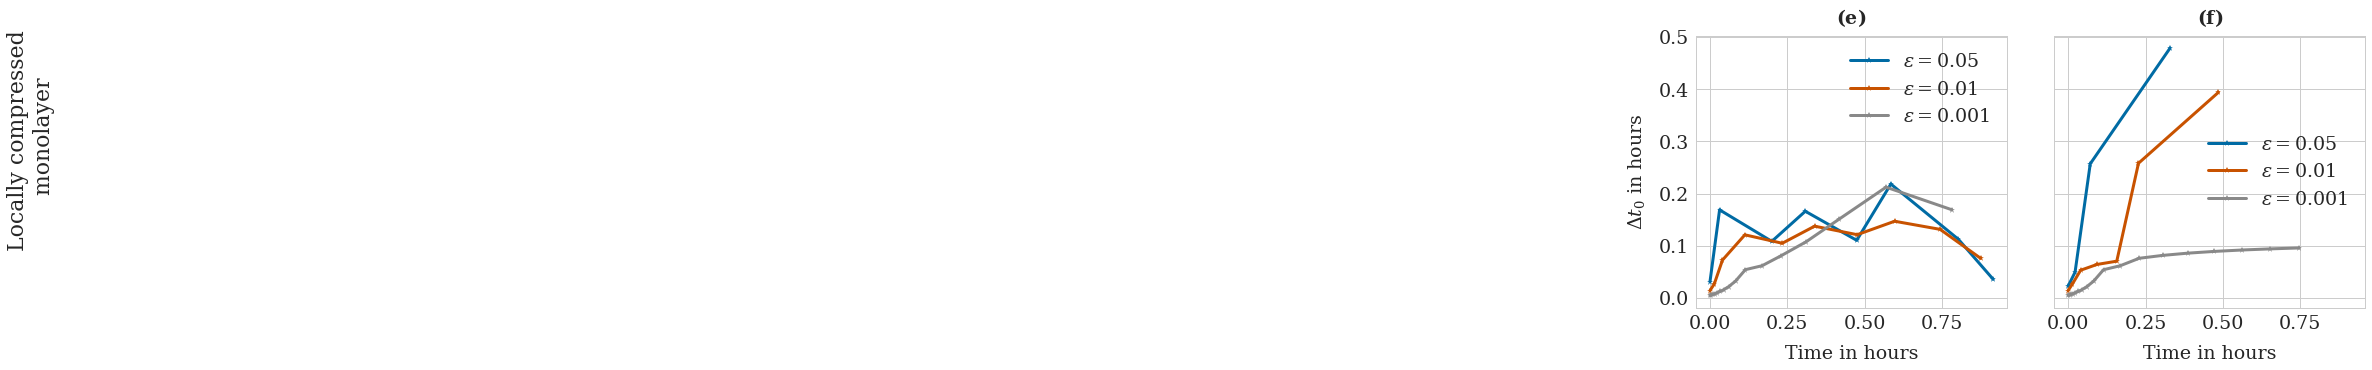

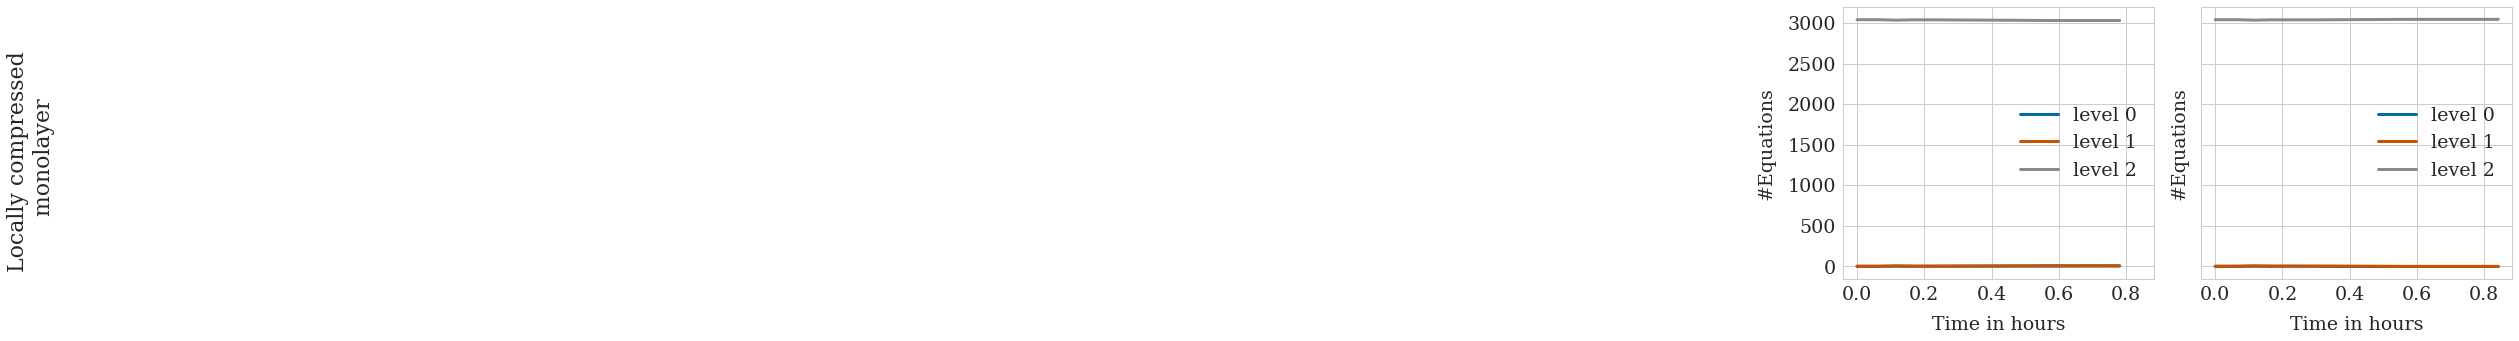

In [18]:
colors = [defcolors[0], defcolors[5], defcolors[6]]
# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

#ax1 No Jacobian - accuracy bound only
#ax1.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2])
#ax1.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax1.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

force = 'cubic'
epsilons = [0.05, 0.01, 0.001]

for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True, "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    ax1.plot(ts[:-1], dts,'-*', label='$\epsilon=$'+str(eps), color=colors[i])




ax1.legend()
ax1.set_title(r'$\bf{(e)}$')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t_0$ in hours')
#ax1.set(ylim=[-0.1, 1.2])
ax1.text(-5.5, 0.1, 'Locally compressed\n        monolayer', fontsize=22, rotation='vertical')
#ax1.text(3.7, 1.45, '$\epsilon=0.01$', fontsize=22)

n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
ax3.plot(ts[:-1], n_eq_per_level[0,:], label='level 0', color=colors[0])
ax3.plot(ts[:-1], n_eq_per_level[1,:], label='level 1', color=colors[1])
ax3.plot(ts[:-1], n_eq_per_level[2,:], label='level 2', color=colors[2])
ax3.legend()
ax3.set(xlabel='Time in hours')
ax3.set(ylabel='#Equations')
ax3.text(-5.5, 0.1, 'Locally compressed\n        monolayer', fontsize=22, rotation='vertical')


#ax2
#ax2.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2])
#ax2.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax2.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )


for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], "local_adaptivity": True, "switch":True, "K":3}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax2.plot(ts[:-2], dts[:-1], '-*', label='$\epsilon=$'+str(eps), color=colors[i])

ax2.set_title(r'$\bf{(f)}$')
ax2.legend()
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t$ in hours')
#ax2.set(ylim=[-0.1, 1.2])
#ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
ax4.plot(ts[:-1], n_eq_per_level[0,:], label='level 0', color=colors[0])
ax4.plot(ts[:-1], n_eq_per_level[1,:], label='level 1', color=colors[1])
ax4.plot(ts[:-1], n_eq_per_level[2,:], label='level 2', color=colors[2])
ax4.legend()
ax4.set(xlabel='Time in hours')
ax4.set(ylabel='#Equations')

plt.savefig('local_adap_local_mono.pdf', bbox_inches='tight')